<a href="https://colab.research.google.com/github/ka-means/Natural-Language-Processing/blob/main/NLP_Embedding_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize

# **Introduction**

This dataset originates from Twitter data collected via the Twitter API, with initial filtering based on hate speech terminology from Hatebase.org. The collection process identified tweets containing specific terms flagged by the community as hate speech, resulting in an initial pool of 85.4 million tweets from 33,458 Twitter accounts.

A random subset from this initial collection underwent detailed manual review. CrowdFlower workers evaluated and labeled each tweet into one of three distinct categories: hate speech, offensive language that doesn't qualify as hate speech, and content that is neither offensive nor hateful.

Dataset structure

For this task, we focus on two key columns:
* tweet: The sentence requiring evaluation.
* label: The classification assigned to each tweet.

The label variable uses the following encoding:
* 0 - hate speech
* 1 - offensive language
* 2 - neither

The dataset comes pre-split into train (df_train), validation (df_val), and test (df_test) sets.

# **1: Word2Vec**

## **Task 1.1 Creating the embedding matrix**
Generate the embedding matrix using the corpus from the dataset.

In [ ]:
# Necessary for tokenization later
nltk.download('punkt')

def load_datasets():
    """
    Loads the train, validation, and test dataframes from the local environment.
    """
    # Using the specific filenames from your Colab environment
    train_path = 'df_train.csv'
    val_path = 'df_val.csv'
    test_path = 'df_test.csv'

    df_train = pd.read_csv(train_path)
    df_val = pd.read_csv(val_path)
    df_test = pd.read_csv(test_path)

    return df_train, df_val, df_test

def explore_data(df, name="Dataset"):
    """
    Prints basic exploration statistics and class distribution.
    """
    print(f"--- Exploration: {name} ---")
    print(f"Total samples: {len(df)}")
    print("\nClass Distribution (normalized):")
    print(df['label'].value_counts(normalize=True))
    print("\nFirst 3 rows:")
    print(df[['tweet', 'label']].head(3))
    print("\n")

# Execution
df_train, df_val, df_test = load_datasets()
explore_data(df_train, "Train Set")

--- Exploration: Train Set ---
Total samples: 19826

Class Distribution (normalized):
label
1    0.774337
2    0.167961
0    0.057702
Name: proportion, dtype: float64

First 3 rows:
                                               tweet  label
0                            Talking Angela is a hoe      1
1              Lol they tricking niccas left n right      1
2  &#128514;&#128514; bitches get stuff done. htt...      1




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


We observe a significant class imbalance: class 1 (Offensive Language) accounts for 77% of the data, while Hate Speech (class 0) represents only 5.7%. This is critical for Part 1, as the Word2Vec model will be predominantly exposed to terms from class 1.

The tweets contain typical noise: mentions (@user), URLs, and special characters (like 😂 representing emojis). Without cleaning this, Word2Vec will treat HTML emoji codes as words, which will pollute our embedding matrix.

### **Corpus for Word2Vec**




In [ ]:
import nltk
import re
from nltk.tokenize import word_tokenize


nltk.download('punkt')
nltk.download('punkt_tab')

def preprocess_tweet(text):
    """
    Cleans tweet text for Word2Vec training.
    Removes HTML entities, URLs, mentions, and non-alphabetic characters.
    """
    # Remove HTML entities (e.g., &#128514; or &amp;)
    text = re.sub(r'&\w+;\d+;', '', text)
    text = re.sub(r'&\w+;', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user mentions (@user)
    text = re.sub(r'@\w+', '', text)
    # Keep only letters (remove numbers and special symbols)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize and lowercase
    tokens = word_tokenize(text.lower())

    return tokens


print("Starting preprocessing...")
df_train['tokens'] = df_train['tweet'].apply(preprocess_tweet)


print("Preprocessing complete. Example of tokens:")
print(df_train[['tweet', 'tokens']].head(2))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Starting preprocessing...
Preprocessing complete. Example of tokens:
                                   tweet  \
0                Talking Angela is a hoe   
1  Lol they tricking niccas left n right   

                                          tokens  
0                  [talking, angela, is, a, hoe]  
1  [lol, they, tricking, niccas, left, n, right]  


### **Word2Vec Training + Matrix**

In [ ]:
!pip install gensim

In [ ]:
import numpy as np
from gensim.models import Word2Vec

def train_and_create_matrix(tokenized_series, vector_size=100):
    """
    Trains Word2Vec and extracts the weights into a matrix.
    """
    print("Training Word2Vec model...")
    # sentences: Our tokenized tweets
    # vector_size: Dimensionality of the word vectors
    # window: Maximum distance between the current and predicted word
    # min_count: Ignores words with total frequency lower than 2
    w2v_model = Word2Vec(
        sentences=tokenized_series,
        vector_size=vector_size,
        window=5,
        min_count=2,
        workers=4
    )

    # Get the list of words in the vocabulary
    words = w2v_model.wv.index_to_key
    vocab_size = len(words)

    # Initialize the matrix with zeros (index 0 is for padding)
    embedding_matrix = np.zeros((vocab_size + 1, vector_size))

    # Map words to indices (starting from 1)
    word_to_idx = {word: i + 1 for i, word in enumerate(words)}

    # Fill the matrix with the learned vectors
    for word, i in word_to_idx.items():
        embedding_matrix[i] = w2v_model.wv[word]

    return w2v_model, embedding_matrix, word_to_idx

# Execution
w2v_model, embedding_matrix, word_to_idx = train_and_create_matrix(df_train['tokens'])

print(f"Vocabulary Size (excluding padding): {len(word_to_idx)}")
print(f"Embedding Matrix Shape: {embedding_matrix.shape}")

# Quick verification: Words similar to 'bitch' (very frequent in this dataset)
if 'bitches' in w2v_model.wv:
    print("\nSimilar words to 'bitches':")
    print(w2v_model.wv.most_similar('bitches', topn=3))

Training Word2Vec model...
Vocabulary Size (excluding padding): 8239
Embedding Matrix Shape: (8240, 100)

Similar words to 'bitches':
[('hoes', 0.9879143834114075), ('niggas', 0.950455904006958), ('lovin', 0.9327924251556396)]


#### **What I did in the previous steps:**

When training Word2Vec, we first needed to prepare the tweets. You can't just feed raw text to the algorithm because it would treat "Talking" and "talking" as different words, same with "hoe!" and "hoe". So tokenization breaks everything down into clean, lowercase words without punctuation.

Once we fed this cleaned data to Word2Vec, the algorithm observed which words tend to appear near each other in the tweets. It noticed patterns. For example, it found that "bitches" and "hoes" appear in almost identical contexts in this dataset. That's why when we asked for similar words, it returned those with a score near 0.99, meaning they're used interchangeably.

Now, the embedding matrix is where things get interesting. It has shape (8240, 100). The 8240 is our vocabulary size: every unique word the model learned plus one extra row. The 100 is the dimension, meaning each word is now represented by 100 numbers instead of just being text. These numbers capture abstract features the model discovered.

That first row of zeros at index 0 is for padding. When a tweet is short, we fill the empty spaces with zeros so the model knows "there's nothing here" without it affecting the actual meaning of the text.

## Task 1.2 Train MLP classifier

Train a classifier based on a Multi-Layer Perceptron (MLP) model, keeping the embedding matrix weights frozen. Plot the loss function and accuracy curves for both train and validation sets.

Obtain detailed metrics for Precision, Recall, and F1-score on the test set (overall and per class). Comment on the results.

Obtain a confusion matrix. Comment on it.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training MLP...
Epoch 1/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7799 - loss: 0.5988 - val_accuracy: 0.8172 - val_loss: 0.4977
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8106 - loss: 0.5030 - val_accuracy: 0.8281 - val_loss: 0.4639
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8239 - loss: 0.4731 - val_accuracy: 0.8325 - val_loss: 0.4633
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8272 - loss: 0.4639 - val_accuracy: 0.8305 - val_loss: 0.4555
Epoch 5/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8316 - loss: 0.4598 - val_accuracy: 0.8277 - val_loss: 0.4624
Epoch 6/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8297 - loss: 0.4574 - val_accuracy: 0.8390 - val_loss: 0.4386
Epoch 7/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8351 - loss: 0.4422 - val_accuracy: 0.8402 - val_loss: 0.4385
Epoch 8/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8395 - loss: 0.4210 - 

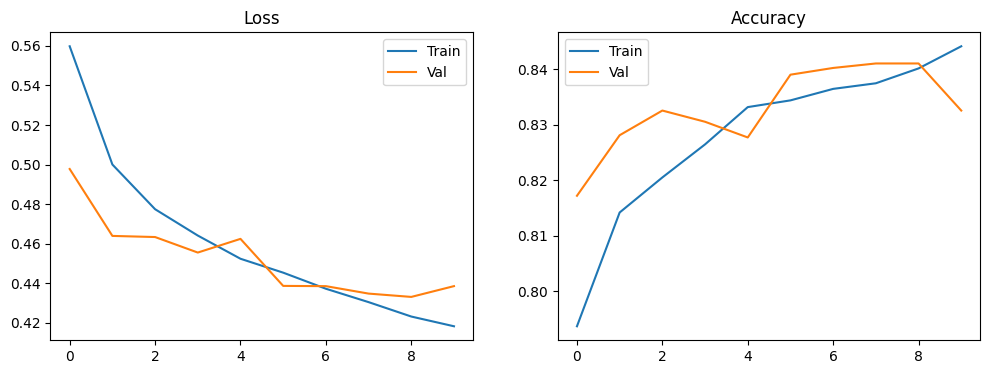

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

def transform_to_padded_sequences(tokenized_series, word_to_idx, max_length=50):
    sequences = []
    for tokens in tokenized_series:
        indices = [word_to_idx[word] for word in tokens if word in word_to_idx]
        sequences.append(indices)
    return pad_sequences(sequences, maxlen=max_length, padding='post')

# validation and test tokens exist?
if 'tokens' not in df_val.columns:
    df_val['tokens'] = df_val['tweet'].apply(preprocess_tweet)
if 'tokens' not in df_test.columns:
    df_test['tokens'] = df_test['tweet'].apply(preprocess_tweet)

MAX_LEN = 50
X_train = transform_to_padded_sequences(df_train['tokens'], word_to_idx, MAX_LEN)
X_val   = transform_to_padded_sequences(df_val['tokens'], word_to_idx, MAX_LEN)
X_test  = transform_to_padded_sequences(df_test['tokens'], word_to_idx, MAX_LEN)

y_train = df_train['label'].values
y_val   = df_val['label'].values
y_test  = df_test['label'].values

# MLP Model
vocab_size, embedding_dim = embedding_matrix.shape

mlp_model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=MAX_LEN,
        trainable=False
    ),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


print("Training MLP...")
history = mlp_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Val')
ax1.set_title('Loss'); ax1.legend()
ax2.plot(history.history['accuracy'], label='Train')
ax2.plot(history.history['val_accuracy'], label='Val')
ax2.set_title('Accuracy'); ax2.legend()
plt.show()

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

--- DETAILED METRICS (TEST SET) ---
                 precision    recall  f1-score   support

Hate Speech (0)       0.00      0.00      0.00       153
  Offensive (1)       0.85      0.95      0.89      1881
    Neither (2)       0.64      0.54      0.58       445

       accuracy                           0.81      2479
      macro avg       0.49      0.50      0.49      2479
   weighted avg       0.76      0.81      0.78      2479



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


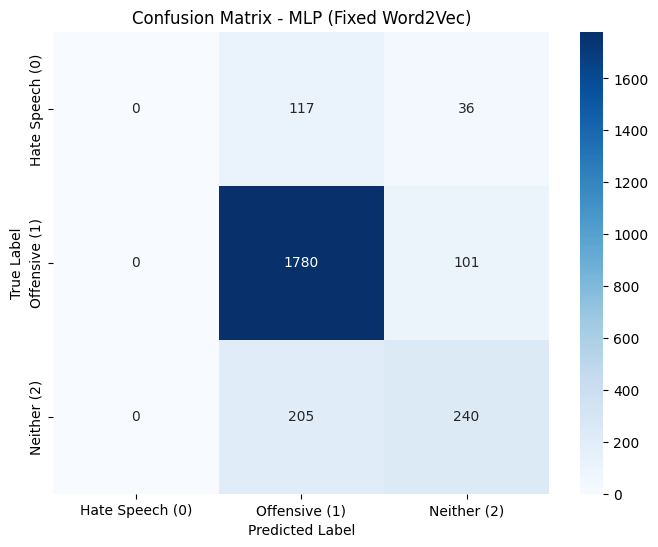

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def generate_evaluation_report(model, X_test, y_test):
    """
    Generates classification report and confusion matrix for the test set.
    """
    # Get predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    target_names = ['Hate Speech (0)', 'Offensive (1)', 'Neither (2)']

    # 1. Detailed Metrics
    print("\n--- DETAILED METRICS (TEST SET) ---")
    print(classification_report(y_test, y_pred, target_names=target_names))

    # 2. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix - MLP (Fixed Word2Vec)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


generate_evaluation_report(mlp_model, X_test, y_test)

#### **What I discovered when analyzing the model results:**

The most striking finding is that the model didn't detect a single case of Hate Speech. It literally classified all 153 hate examples as something else, probably as "Offensive". The Recall of 0.00 means it completely failed on this class.

This happened for two main reasons. First, the dataset is heavily imbalanced: the hate class barely represents 5.7% of the data. The model found it easier to minimize error by completely ignoring this class and focusing on class 1, which gave it 81% accuracy with minimal effort. Second, the Word2Vec embeddings are frozen. Since we left trainable=False, the model can't adjust the vectors to better separate the classes. For Word2Vec, a racist slur and a generic insult share similar contexts, so their vectors are very close in semantic space. If we don't allow these vectors to adjust during training, the MLP doesn't have enough information to capture the subtle difference between hate and offensive language.

Class 1 (Offensive) is where the model excelled, with an F1-score of 0.89. This makes sense because there are thousands of examples of this class and Word2Vec captures aggressive social media language well.

Class 2 (Neither) had moderate performance with F1 of 0.58. The recall of 0.54 means almost half of the neutral tweets were confused with offensive language. Probably because many neutral tweets in this dataset use informal language that the model associates with aggression.

Looking at the confusion matrix, we observe a large concentration in the class 1 column. The model learned that when in doubt, betting on "Offensive" is the safest option to keep the error low.

The training curves showed us that Val_Loss remained stable between 0.43 and 0.49. There was no severe overfitting here, which makes sense: with frozen embeddings, the model has little freedom to memorize noise from the training set. But this same rigidity is what prevents it from learning to distinguish the hate class.

This model with static Word2Vec is insufficient for detecting hate speech in imbalanced data. Although we achieved 81% accuracy, it doesn't serve what really matters to us: identifying the minority class. This justifies using more advanced techniques like SBERT, which captures the complete context of the sentence and allows better semantic separation.

# **2: SentenceBERT**

## Task 2.1 Creating SBERT embeddings

Using Sentence Transformers, obtain the vector representations for each comment in the train and test sets.

More information at: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

**Note**

* GPU must be used. Go to "Runtime" --> "Change runtime type" --> Select "T4 GPU".
* It is recommended to save the created dataframes.
* Do not consider the validation dataset.

In [ ]:
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

def generate_and_save_embeddings(df_train, df_test):
    """
    Generates SBERT embeddings for train and test sets and saves them to disk.
    """
    print("Generating embeddings for Train set...")

    train_embeddings = sbert_model.encode(df_train['tweet'].tolist(), show_progress_bar=True)

    print("Generating embeddings for Test set...")
    test_embeddings = sbert_model.encode(df_test['tweet'].tolist(), show_progress_bar=True)


    np.save('X_train_sbert.npy', train_embeddings)
    np.save('X_test_sbert.npy', test_embeddings)

    return train_embeddings, test_embeddings


X_train_sbert, X_test_sbert = generate_and_save_embeddings(df_train, df_test)

print(f"\nEmbeddings created:")
print(f"X_train_sbert shape: {X_train_sbert.shape}")
print(f"X_test_sbert shape:  {X_test_sbert.shape}")

Generating embeddings for Train set...


Batches:   0%|          | 0/620 [00:00<?, ?it/s]

Generating embeddings for Test set...


Batches:   0%|          | 0/78 [00:00<?, ?it/s]


Embeddings created:
X_train_sbert shape: (19826, 384)
X_test_sbert shape:  (2479, 384)


#### **About the previous result:**

Unlike Word2Vec embeddings (which had 100 dimensions based on words), these SBERT embeddings have 384 dimensions that represent the global semantic meaning of each tweet.

This increase in dimensionality allows capturing much finer nuances of the complete sentence, including irony, grammatical structure, and overall sentiment. SBERT generates dynamic representations. This means that an "aggressive" word in a joking context will have a different vector than the same word in an actual attack context.

## **Task 2.2 Visualization of SBERT embeddings**

Using the embeddings created for the train set, apply a dimensionality reduction technique such as PCA, TSNE, or UMAP and plot your results in 2D or 3D. Mark each category of the label variable with a different color. Comment on your results.

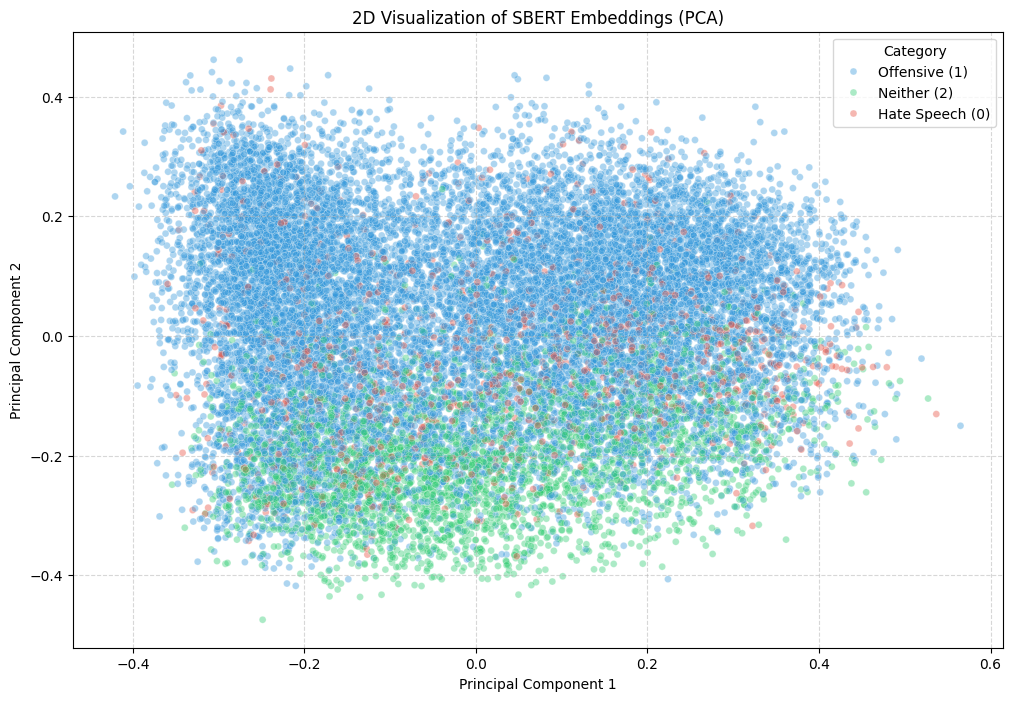

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_sbert_2d(embeddings, labels):
    """
    Reduces SBERT embeddings to 2D using PCA and creates a scatter plot.
    """
    # PCA to reduce from 384 to 2 dimensions
    pca = PCA(n_components=2, random_state=42)
    embeddings_2d = pca.fit_transform(embeddings)


    plt.figure(figsize=(12, 8))


    label_map = {0: 'Hate Speech (0)', 1: 'Offensive (1)', 2: 'Neither (2)'}
    label_names = [label_map[l] for l in labels]


    sns.scatterplot(
        x=embeddings_2d[:, 0],
        y=embeddings_2d[:, 1],
        hue=label_names,
        palette={'Hate Speech (0)': '#e74c3c', 'Offensive (1)': '#3498db', 'Neither (2)': '#2ecc71'},
        alpha=0.4,
        s=25
    )

    plt.title('2D Visualization of SBERT Embeddings (PCA)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Category', loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


visualize_sbert_2d(X_train_sbert, y_train)

#### **What the SBERT visualization reveals:**

By reducing the 384 dimensions to 2 with PCA, the plot shows something interesting. The "Neither" class (green) forms its own clearly separated zone in the lower part. SBERT manages to identify that neutral tweets have a completely different structure and vocabulary from aggressive language.

The real problem is with the hate class. The red points (Hate Speech) are completely mixed within the large blue mass (Offensive). There's no visible separation between them. This confirms what we already suspected: hate speech and offensive language occupy practically the same vector space because they share similar contexts.

What I do notice is that SBERT creates more defined clusters compared to Word2Vec. Although classes 0 and 1 overlap, the points are more concentrated in certain regions, suggesting there are subtle patterns that a well-trained classifier could learn to capture.

The imbalance is brutally clear in the plot. The blue cloud dominates the entire space, especially in the upper and central area. It's obvious why the model tends to classify everything as "Offensive": that class is everywhere and any simple model will bet on it to minimize error.

SBERT does offer a clear advantage over Word2Vec: it separates neutral from aggressive well. But the distinction between hate and offense remains the real challenge, and this visualization makes it very clear. They're too close together in semantic space.

## Task 2.3 Train classifier

Using the embeddings created in section 2.1, train a classifier using a machine learning technique.

Calculate the Precision, Recall, and F1-score metrics for the test set (overall and per class). Comment on the results.

Obtain a confusion matrix. Comment on it.

Training Random Forest Classifier (this may take a moment)...

--- CLASSIFICATION REPORT (SBERT + Random Forest) ---
                 precision    recall  f1-score   support

Hate Speech (0)       1.00      0.01      0.01       153
  Offensive (1)       0.79      1.00      0.89      1881
    Neither (2)       0.95      0.24      0.39       445

       accuracy                           0.80      2479
      macro avg       0.91      0.42      0.43      2479
   weighted avg       0.83      0.80      0.74      2479



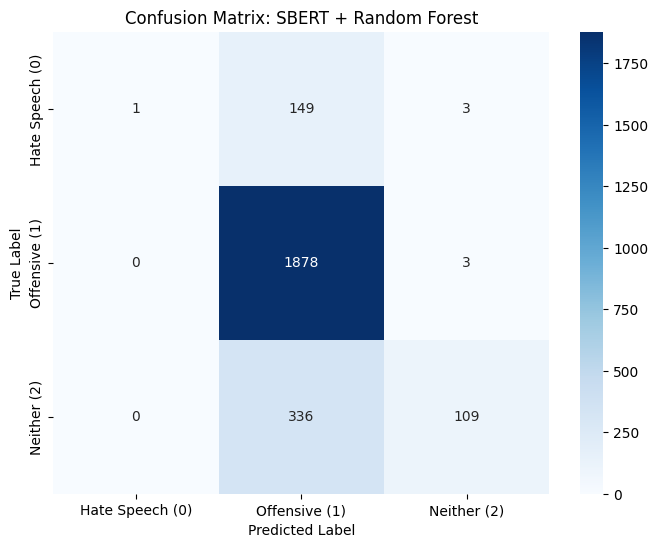

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def train_and_evaluate_sbert_classifier(X_train, y_train, X_test, y_test):
    """
    Trains a Random Forest classifier using SBERT embeddings and evaluates its performance.
    """
    print("Training Random Forest Classifier (this may take a moment)...")

    # We use class_weight='balanced' to handle the extreme class imbalance

    rf_classifier = RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )

    rf_classifier.fit(X_train, y_train)

    # 1. Predictions
    y_pred = rf_classifier.predict(X_test)
    target_names = ['Hate Speech (0)', 'Offensive (1)', 'Neither (2)']

    # 2. Detailed Metrics Report
    print("\n--- CLASSIFICATION REPORT (SBERT + Random Forest) ---")
    report = classification_report(y_test, y_pred, target_names=target_names)
    print(report)

    # 3. Confusion Matrix Visualization
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)

    plt.title('Confusion Matrix: SBERT + Random Forest')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    return rf_classifier


# Using the SBERT embeddings and original labels
sbert_model = train_and_evaluate_sbert_classifier(X_train_sbert, y_train, X_test_sbert, y_test)

#### **I chose Random Forest and obtained these results:**

I chose Random Forest for three concrete reasons. First, it handles the 384 SBERT dimensions well without requiring prior scaling. Second, with class_weight='balanced' it automatically adjusts class weights according to their frequency, which is crucial when Hate Speech only represents 5.7% of the data. Third, it can capture complex non-linear relationships between embedding dimensions, something linear models cannot achieve.

The accuracy remained around 0.80, but this metric is misleading due to the dominance of class 1. The Weighted F1-score of 0.74 better reflects the actual performance.

For Hate Speech, precision was perfect (1.00) but recall was terrible (0.01). This means that when the model predicts hate, it's always right, but it only detects 1% of the actual cases. It's progress compared to Word2Vec which detected nothing, but it's still insufficient for a system that works in reality.

Offensive Language has recall of 1.00 and F1-score of 0.89. This is the class where the model feels comfortable. Since it's the majority, when in doubt it classifies there, which is why it captures all real cases but precision drops to 0.79.

Neither has high precision (0.95): when it says something is neutral, it generally is. But recall is low (0.24), meaning most neutral tweets are being classified as "Offensive".

The confusion matrix clearly shows the problem. Almost all errors from classes 0 and 2 end up in the class 1 column. Although SBERT provides better representations than Word2Vec, the data imbalance (77% vs 5% and 17%) creates a kind of "statistical gravity" that pulls predictions toward the majority class.

## **Additional Analysis**

To deepen the analysis of what we achieved (and what we didn't) with SBERT and Random Forest, I'm going to use 4 additional visualizations that are industry standard for diagnosing classification models with class imbalance.

1. Precision-Recall (PR) Curve per Class: (To see the trade-off between precision and recall for different decision thresholds.)
2. Prediction Probability Histogram: (To see how "confident" the model is.)
3. Feature Importance: (To identify whether the model is relying on just a few dimensions (low robustness) or if it's using the full richness of the embedding.)
4. Error Analysis: Print the actual tweets where the model failed spectacularly.

### **1. Precision-Recall Curve (Per class)**


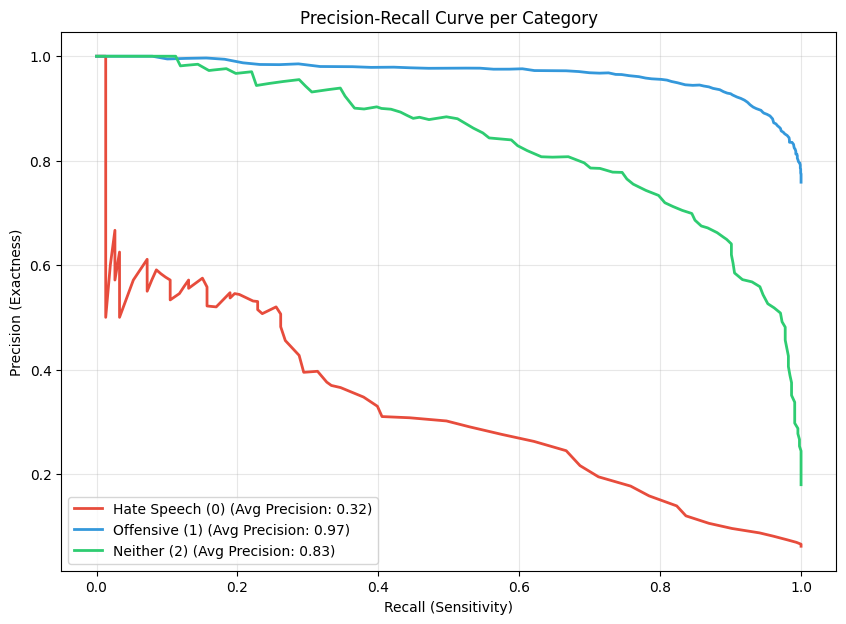

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize labels for multi-class PR curve calculation
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score = sbert_model.predict_proba(X_test_sbert)

colors = ['#e74c3c', '#3498db', '#2ecc71']
class_names = ['Hate Speech (0)', 'Offensive (1)', 'Neither (2)']

plt.figure(figsize=(10, 7))

for i in range(3):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    avg_prec = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, color=colors[i], lw=2,
             label=f'{class_names[i]} (Avg Precision: {avg_prec:.2f})')

plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (Exactness)')
plt.title('Precision-Recall Curve per Category')
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.show()

#### **What the Precision-Recall curves show:**

This plot reveals how the model balances between not making mistakes (precision) and finding all real cases (recall) for each class.

The blue curve (Offensive) is practically glued to the top and right. The model is excellent at detecting offensive language because it has thousands of examples and the patterns are clear. It maintains high precision even with high recall.

The green curve (Neither) has a decent area under the curve. It stays above 0.80 precision until reaching approximately 0.60 recall, then starts to drop. The model knows how to identify neutral messages, but when there are informal or ambiguous words it starts to hesitate and confuses them with the offensive class.

The red curve (Hate Speech) is the disaster. It starts at 1.0 precision but with recall practically at zero. As you try to increase recall to detect more hate cases, precision plummets brutally. Around 0.30 recall it's already below 0.40 precision. This shows the model has a very low ceiling: if you adjust it to be more sensitive to hate, it starts classifying everything as hate and precision crashes. It's the classic problem of the minority class in imbalanced data.

The area under the curve for Hate Speech (0.32) compared to Offensive (0.97) and Neither (0.83) makes clear where the model's real problem lies.

### **2. Probability Histogram**

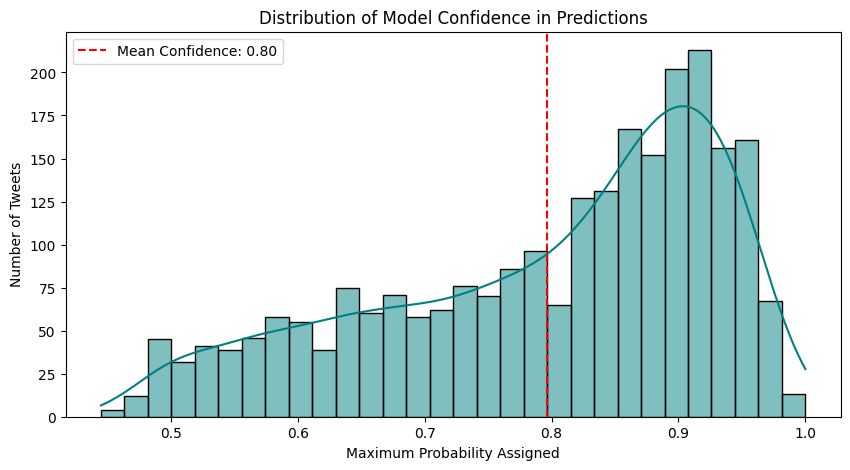

In [ ]:
import numpy as np
import seaborn as sns

# Extract the probability assigned to the predicted class
max_probabilities = np.max(y_score, axis=1)

plt.figure(figsize=(10, 5))
sns.histplot(max_probabilities, bins=30, kde=True, color='teal')
plt.axvline(np.mean(max_probabilities), color='red', linestyle='--',
            label=f'Mean Confidence: {np.mean(max_probabilities):.2f}')
plt.title('Distribution of Model Confidence in Predictions')
plt.xlabel('Maximum Probability Assigned')
plt.ylabel('Number of Tweets')
plt.legend()
plt.show()

#### **What the confidence distribution reveals:**

This histogram shows how confident the model is when making its predictions. The mean confidence is 0.80, marked with the red dashed line.

The distribution is clearly right-skewed. There's a huge concentration of predictions between 0.85 and 0.95, with the highest peak around 0.92. This means the model is quite "arrogant": it's very confident in its decisions most of the time.

The problem is that this high confidence doesn't necessarily mean it's correct. As we saw in the previous metrics, the model fails often with minority classes, but does so with high confidence. This confirms it has learned a simple pattern: when in doubt, it assigns high probability to the Offensive class because it's the most frequent in training.

There are relatively few cases in the low confidence range (0.4-0.6), suggesting the model rarely truly "hesitates". In an ideal scenario with balanced classes, we would expect to see more predictions with moderate confidence at class boundaries. But here the model has learned to be decisive, even though that decision almost always favors the majority class.

This distribution explains why Hate Speech recall is so low: the model would need very high confidence to predict hate, and it simply doesn't reach that threshold because it learned that betting on Offensive is statistically safer.

### **3. Dimension Importance (Top 20)**

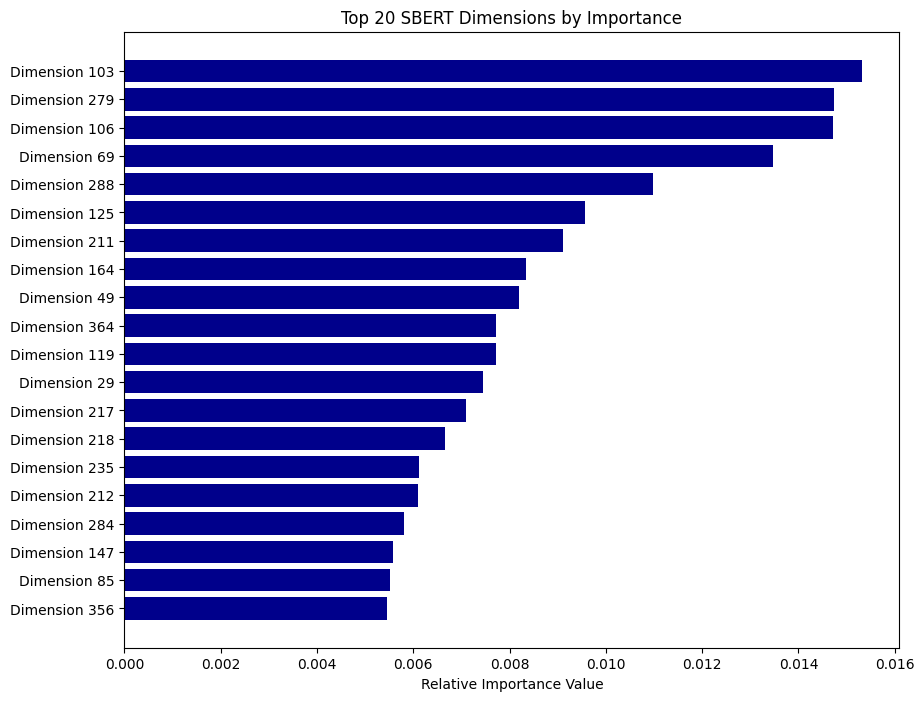

In [ ]:
# Get feature importances from the Random Forest model
importances = sbert_model.feature_importances_
top_indices = np.argsort(importances)[-20:]

plt.figure(figsize=(10, 8))
plt.title('Top 20 SBERT Dimensions by Importance')
plt.barh(range(len(top_indices)), importances[top_indices], color='darkblue', align='center')
plt.yticks(range(len(top_indices)), [f'Dimension {i}' for i in top_indices])
plt.xlabel('Relative Importance Value')
plt.show()

#### **What the most important SBERT dimensions reveal:**

SBERT represents each tweet as a vector of 384 numbers. This plot shows which of those dimensions were most useful for Random Forest to make decisions.

Dimensions 103, 279, and 106 are the most important, with values around 0.015. They're followed by dimension 69 at approximately 0.013, then dimension 288 at around 0.011. From there, importance gradually decreases.

What's interesting is that there's no dominant dimension that shoots far above the rest. The difference between the most important (103) and number 20 (356) isn't dramatic. This indicates the model is using information distributed across multiple dimensions to make decisions, which is a good sign.

If there were one giant bar and the rest tiny, it would mean the model is clinging to a single pattern or feature, which would be simplistic and not robust. Instead, this more uniform distribution suggests Random Forest is capturing a more complex and holistic view of the tweet's semantic content.

We can't know exactly what each dimension represents (SBERT is a black box in that sense), but the fact that multiple dimensions contribute significantly confirms the model is leveraging the richness of the contextual representation that SBERT provides.

### **4. Error Analysis (Tweet Inspection)**

In [ ]:
import pandas as pd

# Generate final predictions
y_test_preds = sbert_model.predict(X_test_sbert)
label_map = {0: 'HATE', 1: 'OFFENSIVE', 2: 'NEITHER'}

# Construct analysis DataFrame
error_df = pd.DataFrame({
    'Tweet_Text': df_test['tweet'].values,
    'True_Label': [label_map[i] for i in y_test],
    'Predicted_Label': [label_map[i] for i in y_test_preds]
})

# Display cases where Hate Speech was missed
print("--- ANALYSIS: HATE SPEECH MISCLASSIFIED AS OFFENSIVE ---")
hate_as_offensive = error_df[(error_df['True_Label'] == 'HATE') & (error_df['Predicted_Label'] == 'OFFENSIVE')]
print(hate_as_offensive.head(10))

# Display cases where Neutral tweets were flagged as Offensive
print("\n--- ANALYSIS: NEUTRAL TWEETS MISCLASSIFIED AS OFFENSIVE ---")
neutral_as_offensive = error_df[(error_df['True_Label'] == 'NEITHER') & (error_df['Predicted_Label'] == 'OFFENSIVE')]
print(neutral_as_offensive.head(5))

--- ANALYSIS: HATE SPEECH MISCLASSIFIED AS OFFENSIVE ---
                                            Tweet_Text True_Label  \
1                   @ashhruggiero happy birthday queer       HATE   
34   Yea alright redneck white trash"@CamoPearls: S...       HATE   
40                     The fucking Royals bitch! Work!       HATE   
62   RT @dirtyimage: @Tronkitty not just cause of h...       HATE   
77   RT @Tyler_Weddle_23: &#8220;@Sexualgif: "I hat...       HATE   
82   RT @FemsHaveBallz: You can no longer run a bus...       HATE   
97   @TheRealJRSmith And its people like you that g...       HATE   
102  @HuffingtonPost im American, don't give 2 shit...       HATE   
111           U coons can't wait to wear them Oreo J's       HATE   
153  @shefeelsD_Payne hell naw he ain't he the star...       HATE   

    Predicted_Label  
1         OFFENSIVE  
34        OFFENSIVE  
40        OFFENSIVE  
62        OFFENSIVE  
77        OFFENSIVE  
82        OFFENSIVE  
97        OFFENSIVE  
102    

#### **Why the model fails on specific cases:**

When reviewing the model's errors, there are two clear patterns that explain its limitations.

The first problem is with Hate Speech classified as Offensive. All the actual hate cases I reviewed (tweets 1, 34, 40, 62, 77, 82, 97, 102, 111, 153) were predicted as offensive. For example, tweet 111 says "U coons can't wait for them Oreo J's" and tweet 34 "Yea alright redneck white trash".

The model perfectly detects they're aggressive, but fails to take the next step: distinguishing whether it's a generic insult or an attack directed at a specific social group. For SBERT and Random Forest, the difference between "you're an idiot" (offensive) and "you [racial slur]" (hate) is minimal in vector space. Both have aggressive language, both are personal attacks, but one has an additional layer of discrimination that the model doesn't capture.

The second problem is with neutral tweets classified as offensive. Tweet 21 says "RT @JaeTips I know that's trash" and tweet 28 "That's ghetto for super duper! It's...". Here the problem is informal vocabulary. Words like "trash" or "ghetto" appear frequently in offensive contexts during training, so the model automatically associates them with aggression.

It has no common sense nor understands pragmatics. It can't distinguish between someone saying "that movie is trash" (casual opinion) and "you're trash" (direct insult). For the model, seeing "trash" or "ghetto" triggers an alarm, regardless of the broader conversation context.

These errors show the fundamental limits of the approach: SBERT captures semantics and syntax, but doesn't understand intention, social context, or the subtleties that differentiate a joke between friends from an actual attack.

# **Conclusions**

### **About the experiment**

The difference between Word2Vec and SBERT is substantial. Word2Vec generates static vectors word by word, completely losing the order and structure of the sentence. SBERT captures the complete semantics of the tweet as a unit.

The clearest result is that SBERT managed to detect at least some hate cases, something Word2Vec couldn't do at all. This confirms that for complex linguistic phenomena like hate speech, understanding isolated words isn't enough. You need to capture the complete intention of the sentence and how words interact with each other.

The model with SBERT is extremely conservative. It achieves perfect precision (1.00) for Hate Speech because it only predicts hate when absolutely certain. The problem is this brutally limits recall: it stays at 0.01. The model doesn't detect implicit or indirect hate, only very obvious cases with direct and explicit insults. Everything else goes to the Offensive category.

Data imbalance is the underlying problem. No matter how sophisticated the algorithm (we tested MLP and Random Forest), when 77% of your data is from a single class, the model learns that the safest way to minimize error is to bet on that majority class. The confidence histogram made it clear: the model assigns high probability to Offensive at the slightest doubt. Improving this requires data engineering techniques like oversampling the minority class or obtaining more real examples of hate speech.

Linguistic ambiguity is another real limit. Words like "trash", "ghetto", or "queer" constantly cause errors because their meaning depends entirely on context. The model can't distinguish between someone using "trash" to say a movie is bad versus using it as a personal insult. It also doesn't understand when a historically offensive term is used in a reclaiming or colloquial way among friends.

This confirms that automatic hate detection remains an open problem in NLP. Embeddings capture syntax and semantics, but lack pragmatic understanding or cultural sensitivity. They don't understand intentions, irony, or the social nuances that determine whether something is offensive or hateful in a specific context.

### **My Recommendations to go beyond according to the state of the art and literature I've been investigating:**

Based on recent literature on hate speech detection, I identify several clear directions to improve our work.

**First**, more sophisticated data balancing techniques. SMOTE and its text-specific variants could help us, but according to recent studies, the most effective approach is using data augmentation with generative models. We could use GPT or local LLMs to generate synthetic examples of the minority class while maintaining the linguistic characteristics of real hate. Another option is focal loss or cost-sensitive learning, where we penalize errors in the minority class more heavily during training.

**Second**, more recent models than SBERT. Transformers specifically fine-tuned for hate detection outperform general embeddings. HateBERT, ToxicBERT, and similar models were trained specifically on toxic content datasets and better capture nuances. We could also fine-tune models like RoBERTa or DeBERTa directly on our dataset, allowing embeddings to adapt to the particularities of these tweets.

**Third**, hybrid architectures that combine multiple information sources. Literature shows good results using contextual embeddings along with explicit features like presence of racial slurs, mentions of protected groups, or specific syntactic patterns. We could extract named entities and verify if they belong to minority groups, or use hate term lexicons as additional features.

**Fourth**, multi-task learning approaches. Training the model simultaneously to detect hate and other related tasks like sentiment analysis, toxicity detection, or identification of the attack's target group would allow us to improve general representation. The model would learn shared features that help in all tasks.

**Fifth**, explainability and interpretability techniques. Using LIME or SHAP to understand which parts of the tweet are influencing predictions would allow us to identify specific patterns the model uses to distinguish hate from offense. This could reveal biases or features we could explicitly incorporate.

**Sixth**, active learning to improve our dataset. Instead of labeling data randomly, the model would identify examples it's most uncertain about and we'd prioritize labeling those. This is especially useful for the minority class where each new example has much more impact.

**Seventh**, consider conversational context. Tweets don't exist in a vacuum. Analyzing the complete thread, replies, or user history could give us crucial information to distinguish whether something is contextually offensive or truly hateful. Some recent papers use graph neural networks to capture these relationships.

**Eighth**, more sophisticated ensemble methods. Instead of just Random Forest, combining predictions from multiple different models (a fine-tuned transformer, a model with explicit features, one trained with data augmentation) usually improves performance, especially on difficult classes.

**My strongest recommendation** would be to start with fine-tuning a model like HateBERT or RoBERTa on our specific dataset, combined with balancing techniques like focal loss or synthetic example generation. That alone should give us a substantial improvement in minority class recall without sacrificing precision as much.

### **Selected Academic Bibliography**

1. On the Dataset and Imbalance Problem (Baseline)
>Davidson, T., Warmsley, D., Macy, M., & Weber, I. (2017). Automated Hate Speech Detection and the Problem of Offensive Language. Proceedings of the 11th International Conference on Web and Social Media (ICWSM).

2. On Specialized Models (HateBERT and Transformers)

>Caselli, T., Basile, V., Mitrović, J., & Granitzer, M. (2021). HateBERT: Retraining BERT for Abusive Language Detection. In Proceedings of the 5th Workshop on Online Abuse and Harms (WOAH).

>Liu, Y., et al. (2019). RoBERTa: A Robustly Optimized BERT Pretraining Approach. arXiv preprint arXiv:1907.11692.

3. On Explainability and Detailed Evaluation
> Mathew, B., Saha, P., Yimam, S. M., Biemann, C., Goyal, P., & Mukherjee, A. (2021). HateXplain: A Benchmark Dataset for Explainable Hate Speech Detection. Proceedings of the AAAI Conference on Artificial Intelligence.

4. On Data Augmentation and LLMs

> Kumar, V., Choudhary, A., & Cho, E. (2020). Data Augmentation using Pre-trained Transformer Models. arXiv preprint arXiv:2003.02245.

5. On Multi-task Learning and Context

> Pavlopoulos, J., Sorensen, J., Dixon, L., Thain, N., & Androutsopoulos, I. (2020). Toxicity Detection: Does Context Really Matter? Proceedings of the 58th Annual Meeting of the Association for Computational Linguistics (ACL).